# Ship Route Optimization

When traveling on the surface of the Earth one cannot take a constant heading to travel the shortest route from point **A** to **B**. 

Instead, the heading must be constantly readjusted so that the arc of the trajectory corresponds to the intersection between the globe and a plane that passes through the center of the Earth. 

For ships the ocean currents are an important factor which can be harnessed to produce the optimal path.

## Operation

- This app generates a **Graph** with the (latitude, longitude) grid of ocean points around the globe as vertices.
- Edges are the **8-point** ocean neighbours with weights being the time taken by the ship to travel the length of the edge considering the **Ocean Currents**. 
- This app generates an optimal route for a ship by running **Dijkstra's Shortest Path Algorithm** on this graph with the **Start** and **End** points taken as inputs.


In [63]:
import main
import helper

import numpy as np
import helper
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from pyproj import Geod

In [64]:
# Head waters of Bass Straight Port of Hastings, VIC
start_coord = (-38.3, 145.0)  

# Coordinates Wakayama Bay Port of Kobe, Japan
end_coord = (34.0349, 134.5411)  


boat_avg_speed = 1.0

In [65]:
lon_pre, lat_pre, U_pre, V_pre = main.get_ocean_current_dataset()
lon_post, lat_post, U_post, V_post = main.process_ds(lon_pre, lat_pre, U_pre, V_pre)

# Generate Graph
G = main.graph_factory(lon_post, lat_post, U_post, V_post, boat_avg_speed)

# Get optimal path
path = main.get_optimal_routes(G, start_coord, end_coord, lon_post, lat_post)

# Convert path into list of lat, lon coordinates
xx, yy = main.get_coordinates_from_path_indices(path, lon_post, lat_post)

# densify to N segments for DB / plotting
num_legs = 100
xx_dense, yy_dense, time_total_dist = helper.densify_route(xx, yy, num_legs)

print(len(xx_dense))

100


In [67]:
def plot_matplot(lon, lat, U, V, xx, yy):
    """
    Generates result plot

    Parameters
    ----------
    lon: array
        1D array containing longitude points
    lat: array
        1D array containing latitude points
    U: array
        2D array containing x component of ocean current speeds [shape -> (len(lat), len(lon))]
    V: array
        2D array containing y component of ocean current speeds [shape -> (len(lat), len(lon))]
    """

    fig, ax = plt.subplots(figsize=(15, 15))
    m = Basemap(width=12000000,height=9000000,resolution='l')
    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color='aqua', linewidth=0.5)
    m.fillcontinents(color='coral',lake_color='aqua')

    dec = 5
    lon = lon[::dec]
    lat = lat[::dec]
    U = U[::dec, ::dec]
    V = V[::dec, ::dec]
    lon, lat, U, V = main.sanitize(lon, lat, U, V)

    m.streamplot(lon, lat, U, V, latlon=True, color=U, linewidth=0.5, cmap='ocean', arrowsize=0.5)

    m.plot(xx, yy, 'k:', linewidth=2, label='Optimal Path', latlon=True)
    m.scatter([xx[0]], [yy[0]], c='g', label='Start', latlon=True)
    m.scatter([xx[-1]], [yy[-1]], c='b', label='End', latlon=True)

    plt.legend()
    return fig, lon

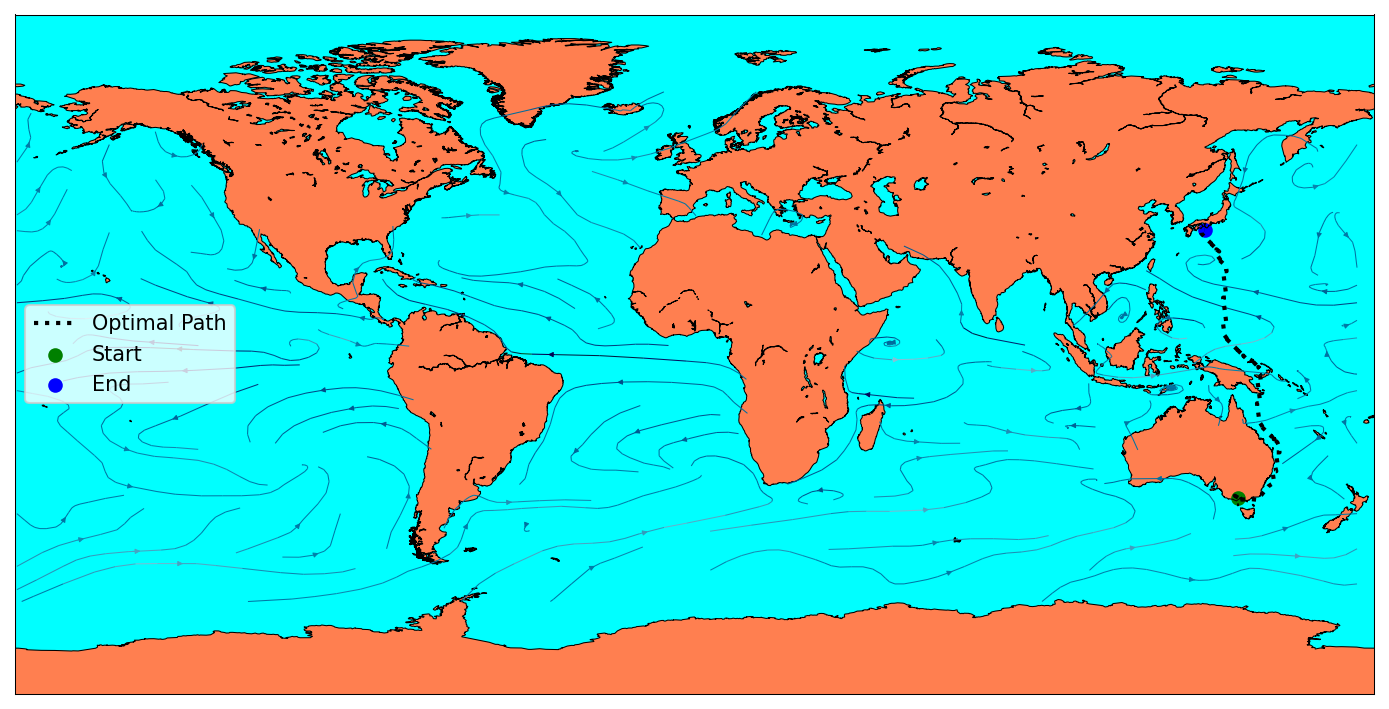

100
100


In [68]:
fig = main.plot_matplot(lon_post, lat_post, U_post, V_post, xx_dense, yy_dense)

plt.rcParams["figure.figsize"] = (12, 6)   # width, height in inches
plt.rcParams["figure.dpi"] = 150          # render resolution
plt.rcParams["savefig.dpi"] = 300

plt.show()

print(len(xx_dense))
print(len(yy_dense))

ROUTE COMPARISON STATISTICS
Distance-Optimal Route (Great Circle): 8080.98 km
Time-Optimal Route (Current-Assisted): 9617.23 km
Difference: 1536.25 km
Time-optimal route is 19.0% longer


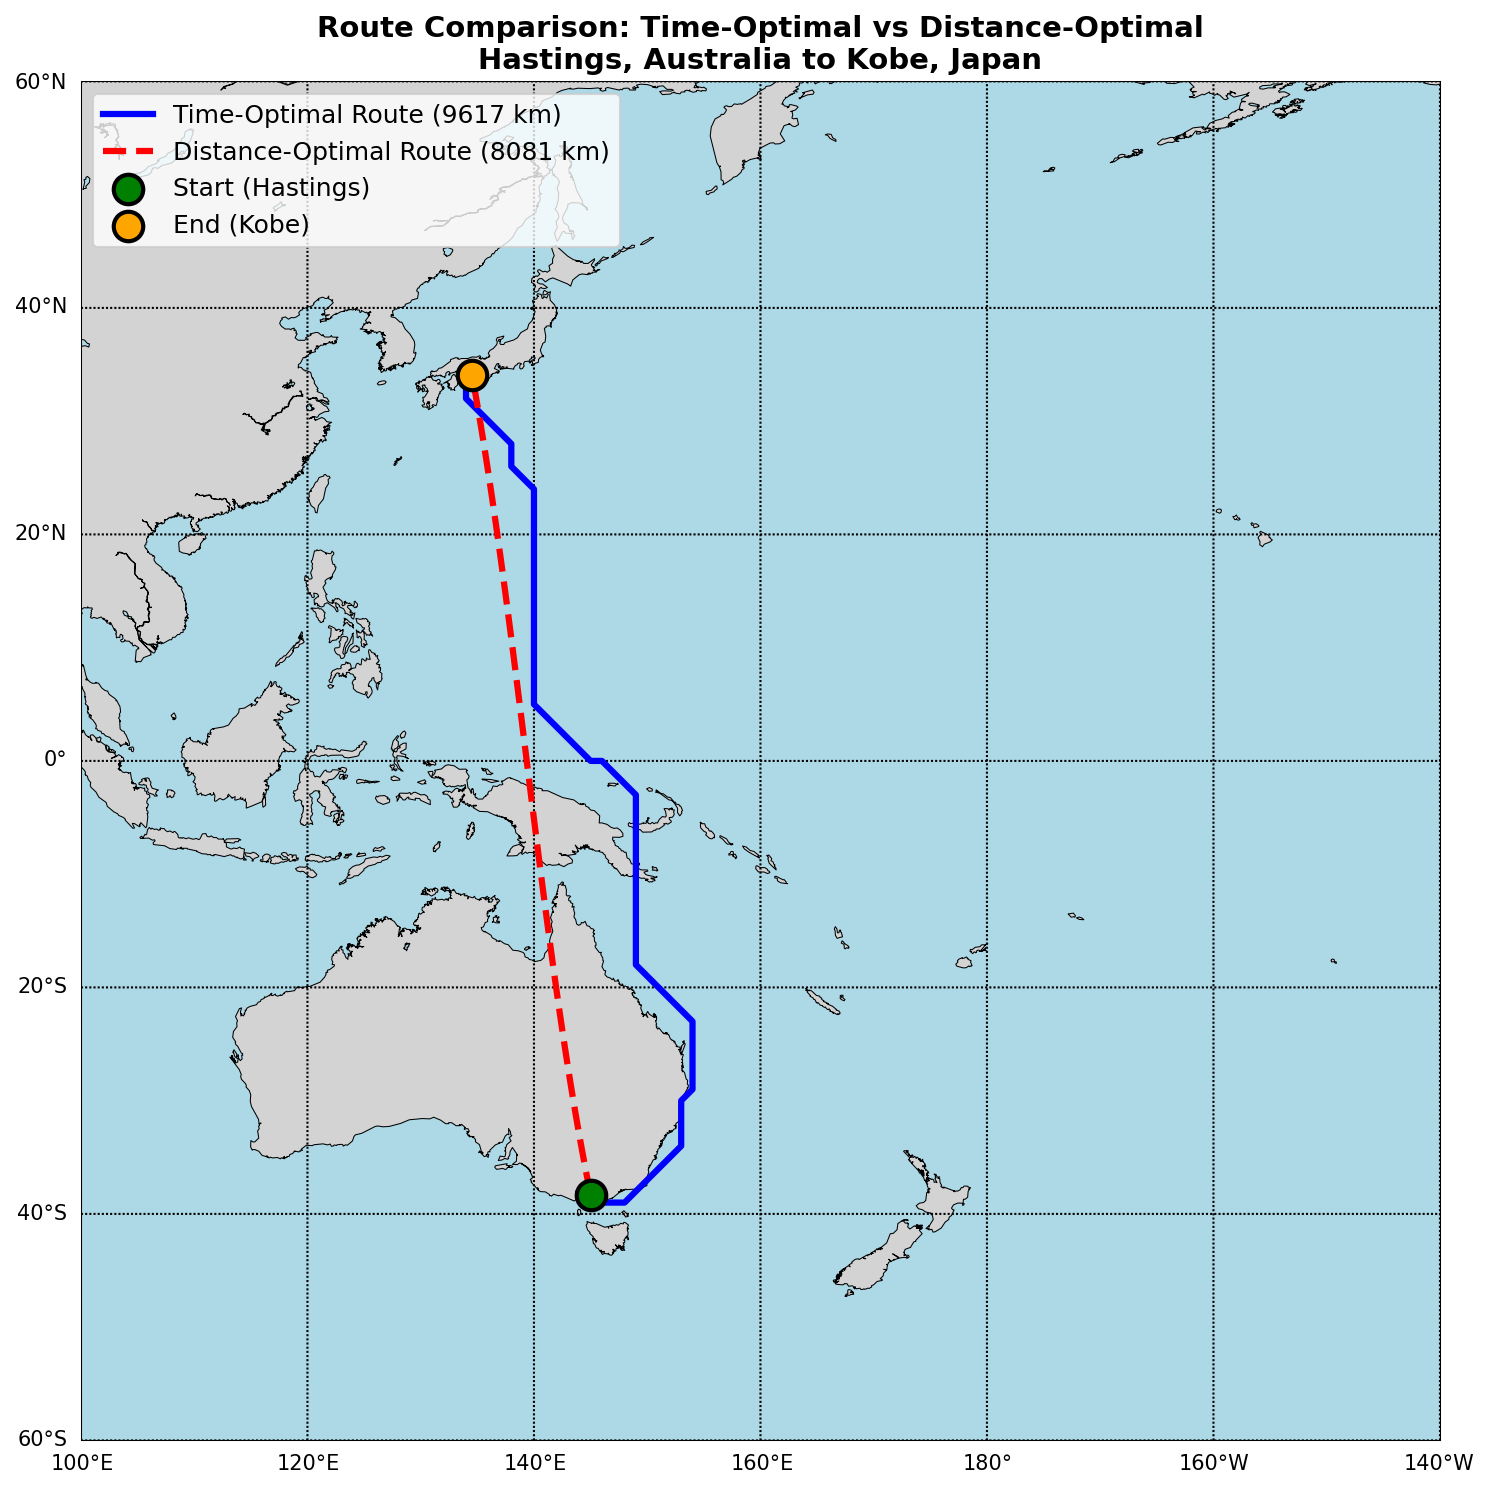

[144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 153. 153. 153. 153.
 154. 154. 154. 154. 154. 154. 154. 153. 152. 151. 150. 149. 149. 149.
 149. 149. 149. 149. 149. 149. 149. 149. 149. 149. 149. 149. 149. 148.
 147. 146. 145. 144. 143. 142. 141. 140. 140. 140. 140. 140. 140. 140.
 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 140. 139.
 138. 138. 138. 137. 136. 135. 134. 134. 134.]
[-38. -39. -39. -39. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30.
 -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16.
 -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.
  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.
  26.  27.  28.  29.  30.  31.  32.  33.  34.]


In [69]:
geod = Geod(ellps="WGS84")


def calculate_distance_optimal_route(start_coord, end_coord, num_points=100):
    """
    Calculate the distance-optimal route (great-circle path) between two points.


    Parameters
    ----------
    start_coord : tuple
        (latitude, longitude) of start point
    end_coord : tuple
        (latitude, longitude) of end point
    num_points : int
        Number of points (including start and end) along the path.


    Returns
    -------
    route_lons : array
        Longitude points along the great-circle route
    route_lats : array
        Latitude points along the great-circle route
    total_distance : float
        Total distance in meters
    """
    start_lat, start_lon = start_coord
    end_lat, end_lon = end_coord


    # Total geodesic distance and azimuth from start to end
    fwd_az, back_az, total_distance = geod.inv(start_lon, start_lat, end_lon, end_lat)


    # Fractions between 0 and 1 for intermediate points
    fractions = np.linspace(0.0, 1.0, num_points)


    route_lats = []
    route_lons = []


    for frac in fractions:
        # Distance along the path at this fraction
        d = total_distance * frac
        lon_i, lat_i, _ = geod.fwd(start_lon, start_lat, fwd_az, d)
        route_lats.append(lat_i)
        route_lons.append(lon_i)


    return np.array(route_lons), np.array(route_lats), total_distance



def plot_comparison(lon_post, lat_post, U_post, V_post,
                    time_opt_lons, time_opt_lats,
                    start_coord, end_coord):
    """
    Plot both time-optimal and distance-optimal routes on the same map
    """
    # Calculate distance-optimal route
    dist_opt_lons, dist_opt_lats, dist_distance = calculate_distance_optimal_route(
        start_coord, end_coord
    )
   
    # Calculate time-optimal route distance
    time_distance = 0
    for i in range(len(time_opt_lats) - 1):
        time_distance += helper.distance(
            time_opt_lats[i], time_opt_lons[i],
            time_opt_lats[i+1], time_opt_lons[i+1]
        )
   
    # Create figure WITHOUT streamplot to avoid the error
    fig, ax = plt.subplots(figsize=(15, 12))
    m = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=60,
                llcrnrlon=100, urcrnrlon=220, resolution='l')
    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color='lightblue', linewidth=0.5)
    m.fillcontinents(color='lightgray', lake_color='lightblue')
    m.drawparallels(np.arange(-60, 61, 20), labels=[1,0,0,0])
    m.drawmeridians(np.arange(100, 221, 20), labels=[0,0,0,1])
   
    # Plot time-optimal route (current-assisted)
    m.plot(time_opt_lons, time_opt_lats, 'b-', linewidth=3,
          label=f'Time-Optimal Route ({time_distance/1000:.0f} km)', latlon=True)
   
    # Plot distance-optimal route (great-circle)
    m.plot(dist_opt_lons, dist_opt_lats, 'r--', linewidth=3,
          label=f'Distance-Optimal Route ({dist_distance/1000:.0f} km)', latlon=True)
   
    # Plot start and end points
    m.scatter([start_coord[1]], [start_coord[0]], c='green', s=200,
             label='Start (Hastings)', latlon=True, zorder=5, edgecolors='black', linewidth=2)
    m.scatter([end_coord[1]], [end_coord[0]], c='orange', s=200,
             label='End (Kobe)', latlon=True, zorder=5, edgecolors='black', linewidth=2)
   
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Route Comparison: Time-Optimal vs Distance-Optimal\nHastings, Australia to Kobe, Japan',
              fontsize=14, fontweight='bold')
   
    # Print statistics
    print("=" * 60)
    print("ROUTE COMPARISON STATISTICS")
    print("=" * 60)
    print(f"Distance-Optimal Route (Great Circle): {dist_distance/1000:.2f} km")
    print(f"Time-Optimal Route (Current-Assisted): {time_distance/1000:.2f} km")
    print(f"Difference: {(time_distance - dist_distance)/1000:.2f} km")
    print(f"Time-optimal route is {((time_distance/dist_distance - 1) * 100):.1f}% longer")
    print("=" * 60)
   
    return fig


# Call the function with your existing variables
fig = plot_comparison(
    lon_post,
    lat_post,
    U_post,
    V_post,
    xx,  # Your time-optimal route longitudes (already calculated)
    yy,  # Your time-optimal route latitudes (already calculated)
    start_coord,  # (-38.29, 145.23)
    end_coord     # (34.69, 135.20)
)


plt.show()


print(xx)
print(yy)

In [70]:
def path_distance(lons, lats):
    """Total great-circle distance along a polyline (meters)."""
    total = 0.0
    for i in range(len(lats) - 1):
        total += helper.distance(
            lats[i],  lons[i],
            lats[i+1], lons[i+1]
        )
    return total


In [78]:
time_distance = path_distance(xx_dense, yy_dense)

print(time_distance/1000)


12581.612810440987


In [79]:
def great_circle_route(start_coord, end_coord, n=200):
    start_lat, start_lon = start_coord
    end_lat, end_lon = end_coord
    fwd_az, _, total_dist = geod.inv(start_lon, start_lat, end_lon, end_lat)
    fracs = np.linspace(0.0, 1.0, n)
    lats = []
    lons = []
    for f in fracs:
        d = total_dist * f
        lon_i, lat_i, _ = geod.fwd(start_lon, start_lat, fwd_az, d)
        lats.append(lat_i)
        lons.append(lon_i)
    return np.array(lons), np.array(lats), total_dist


In [80]:
def plot_comparison(lon_post, lat_post, U_post, V_post,
                    time_opt_lons, time_opt_lats,   # xx_dense, yy_dense
                    start_coord, end_coord):
    """
    Plot both time-optimal (dense) and distance-optimal routes.
    """

    # Distance-optimal (great circle) between start and end
    dist_opt_lons, dist_opt_lats, dist_distance = great_circle_route(
        start_coord, end_coord, n=200
    )

    # Time-optimal distance along dense path
    time_distance = path_distance(time_opt_lons, time_opt_lats)

    fig, ax = plt.subplots(figsize=(15, 12))
    m = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=60,
                llcrnrlon=100, urcrnrlon=220, resolution='l')
    m.drawcoastlines(linewidth=0.5)
    m.drawmapboundary(fill_color='lightblue', linewidth=0.5)
    m.fillcontinents(color='lightgray', lake_color='lightblue')
    m.drawparallels(np.arange(-60, 61, 20), labels=[1,0,0,0])
    m.drawmeridians(np.arange(100, 221, 20), labels=[0,0,0,1])

    # Time-optimal route (dense)
    m.plot(time_opt_lons, time_opt_lats, 'b-', linewidth=3,
           label=f'Time-Optimal Route ({time_distance/1000:.0f} km)', latlon=True)

    # Distance-optimal route (great circle)
    m.plot(dist_opt_lons, dist_opt_lats, 'r--', linewidth=3,
           label=f'Distance-Optimal Route ({dist_distance/1000:.0f} km)', latlon=True)

    m.scatter([start_coord[1]], [start_coord[0]], c='green', s=200,
              label='Start (Hastings)', latlon=True, zorder=5, edgecolors='black', linewidth=2)
    m.scatter([end_coord[1]], [end_coord[0]], c='orange', s=200,
              label='End (Kobe)', latlon=True, zorder=5, edgecolors='black', linewidth=2)

    plt.legend(loc='upper left', fontsize=12)
    plt.title('Route Comparison: Time-Optimal vs Distance-Optimal\n'
              'Hastings, Australia to Kobe, Japan',
              fontsize=14, fontweight='bold')

    print("=" * 60)
    print("ROUTE COMPARISON STATISTICS")
    print("=" * 60)
    print(f"Distance-Optimal Route (Great Circle): {dist_distance/1000:.2f} km")
    print(f"Time-Optimal Route (Current-Assisted): {time_distance/1000:.2f} km")
    print(f"Difference: {(time_distance - dist_distance)/1000:.2f} km")
    print(f"Time-optimal route is {((time_distance/dist_distance - 1) * 100):.1f}% longer")
    print("=" * 60)

    return fig


ROUTE COMPARISON STATISTICS
Distance-Optimal Route (Great Circle): 8080.98 km
Time-Optimal Route (Current-Assisted): 12581.61 km
Difference: 4500.63 km
Time-optimal route is 55.7% longer


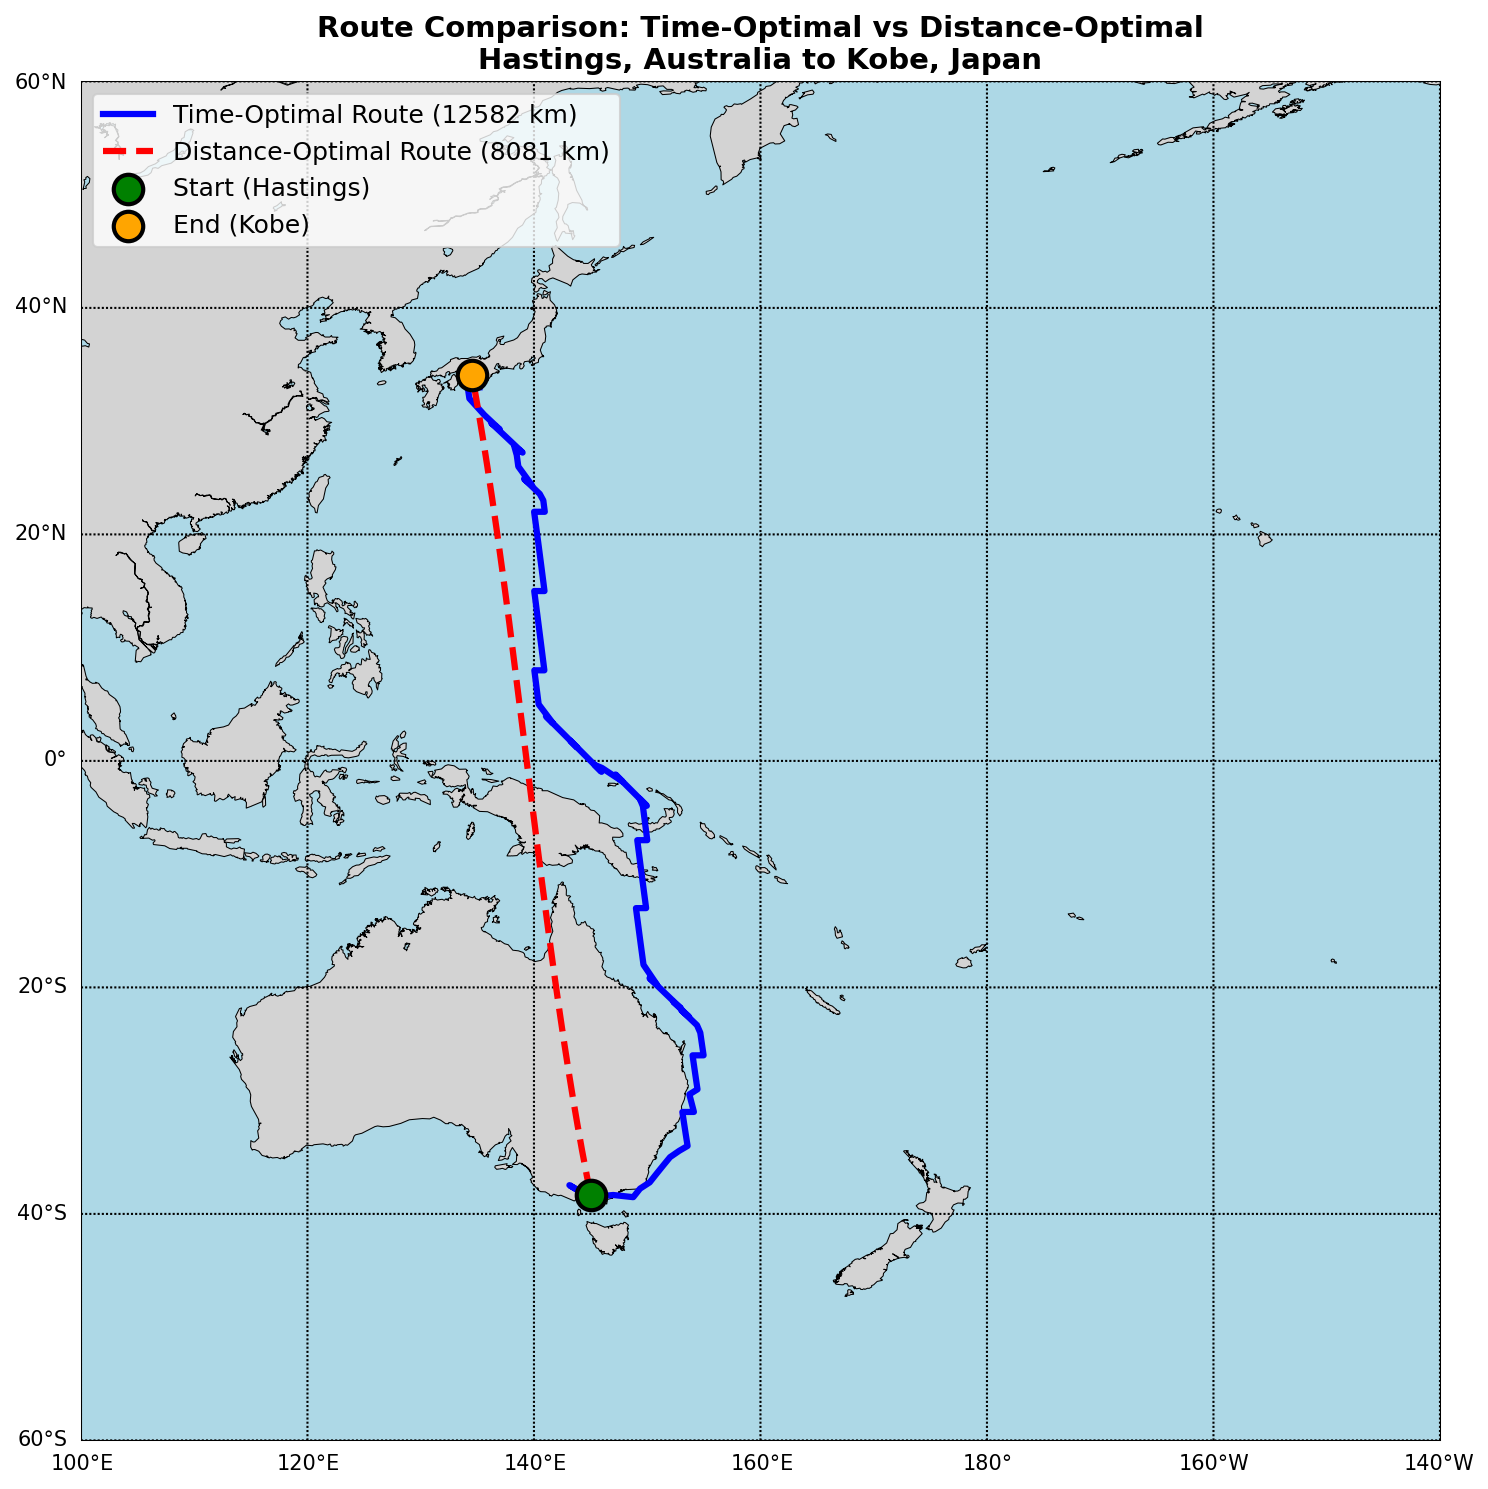

In [81]:
fig = plot_comparison(
    lon_post,
    lat_post,
    U_post,
    V_post,
    xx_dense,   # time-optimal lons
    yy_dense,   # time-optimal lats
    start_coord,
    end_coord
)
plt.show()


In [ ]:
import psycopg2
from psycopg2 import sql
from datetime import datetime
import numpy as np
import helper


def store_routes_in_database(time_opt_lons, time_opt_lats, start_coord, end_coord,
                             db_name, db_user, db_password, db_host='localhost', db_port=5432,
                             route_name='Hastings_to_Kobe'):
    """
    Store both time-optimal and distance-optimal routes in PostgreSQL database
    
    Parameters
    ----------
    time_opt_lons : array
        Longitude points of time-optimal route
    time_opt_lats : array
        Latitude points of time-optimal route
    start_coord : tuple
        (latitude, longitude) of start point
    end_coord : tuple
        (latitude, longitude) of end point
    db_name : str
        Database name
    db_user : str
        Database username
    db_password : str
        Database password
    db_host : str
        Database host (default: localhost)
    db_port : int
        Database port (default: 5432)
    route_name : str
        Name identifier for this route pair
        
    Returns
    -------
    dict
        Summary of inserted records
    """
    
    # Calculate distance-optimal route
    num_points = len(time_opt_lons)  # Use same resolution as time-optimal
    dist_opt_lons, dist_opt_lats, _ = calculate_distance_optimal_route(
        start_coord, end_coord, num_points
    )
    
    # Connect to database
    conn = psycopg2.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port
    )
    cur = conn.cursor()
    
    # Function to insert route points
    def insert_route(lons, lats, route_type):
        cumulative_dist = 0
        records_inserted = 0
        
        for i in range(len(lons)):
            # Calculate distance from previous point
            if i == 0:
                dist_from_prev = 0
            else:
                dist_from_prev = helper.distance(
                    lats[i-1], lons[i-1], 
                    lats[i], lons[i]
                )
                cumulative_dist += dist_from_prev
            
            # Insert point (upsert on conflict)
            insert_query = """
            INSERT INTO voyage_routes 
                (route_name, route_type, point_sequence, latitude, longitude, 
                 distance_from_start, cumulative_distance)
            VALUES (%s, %s, %s, %s, %s, %s, %s)
            ON CONFLICT (route_name, route_type, point_sequence) 
            DO UPDATE SET 
                latitude = EXCLUDED.latitude,
                longitude = EXCLUDED.longitude,
                distance_from_start = EXCLUDED.distance_from_start,
                cumulative_distance = EXCLUDED.cumulative_distance,
                created_at = CURRENT_TIMESTAMP;
            """
            
            cur.execute(insert_query, (
                route_name,
                route_type,
                i,
                float(lats[i]),
                float(lons[i]),
                float(dist_from_prev),
                float(cumulative_dist)
            ))
            records_inserted += 1
        
        return records_inserted, cumulative_dist
    
    # Insert time-optimal route
    print(f"Inserting time-optimal route points...")
    time_records, time_total_dist = insert_route(
        time_opt_lons, time_opt_lats, 'time_optimal'
    )
    
    # Insert distance-optimal route
    print(f"Inserting distance-optimal route points...")
    dist_records, dist_total_dist = insert_route(
        dist_opt_lons, dist_opt_lats, 'distance_optimal'
    )
    
    # Commit and close
    conn.commit()
    cur.close()
    conn.close()
    
    # Summary
    summary = {
        'route_name': route_name,
        'time_optimal': {
            'points': time_records,
            'total_distance_km': time_total_dist / 1000
        },
        'distance_optimal': {
            'points': dist_records,
            'total_distance_km': dist_total_dist / 1000
        }
    }
    
    print("\n" + "=" * 60)
    print("DATABASE STORAGE COMPLETE")
    print("=" * 60)
    print(f"Route Name: {route_name}")
    print(f"\nTime-Optimal Route:")
    print(f"  - Points inserted: {time_records}")
    print(f"  - Total distance: {time_total_dist/1000:.2f} km")
    print(f"\nDistance-Optimal Route:")
    print(f"  - Points inserted: {dist_records}")
    print(f"  - Total distance: {dist_total_dist/1000:.2f} km")
    print("=" * 60)
    
    return summary


In [ ]:
# Store both routes in database
summary = store_routes_in_database(
    time_opt_lons=xx,
    time_opt_lats=yy,
    start_coord=start_coord,
    end_coord=end_coord,
    db_name='postgres',
    db_user='postgres',
    db_password='Test1234',          # or 'Test1234' if that is the actual password
    db_host='localhost',
    db_port=5432,
    route_name='Hastings_to_Kobe_2026'
)

# Query back the data
time_optimal_df = query_route_from_database(
    db_name='postgres',
    db_user='postgres',
    db_password='Test1234',          # or 'Test1234'
    route_name='Hastings_to_Kobe_2026',
    route_type='time_optimal'
)

print(time_optimal_df.head())
